# KFP Challenge Lab 1

In this challenge lab, we'll extend the pipeline developed in [pipelines_prebuild](../solutions/kfp_pipeline_vertex_prebuilt.ipynb) to integrate with Vertex AI Experiments.<br>

**Learning Objectives:**
1. Learn how to handle KFP Artifact.
1. Learn how to define Artifact output in a Python lightweight component.
1. Learn how to use Vertex AI Experiments.

## Setup

In [16]:
from datetime import datetime

from google.cloud import aiplatform

In [17]:
REGION = "us-central1"
PROJECT_ID = !(gcloud config get-value project)
PROJECT_ID = PROJECT_ID[0]

In [18]:
# Set `PATH` to include the directory containing KFP CLI
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin::/home/jupyter/.local/bin:


### Build the trainer image

The training step in the pipeline will require a custom training container. The custom training image is defined in `trainer_image_vertex/Dockerfile`.

Let's now build and push this trainer container to the container registry:

In [96]:
ARTIFACT_REGISTRY_DIR = "asl-artifact-repo"
IMAGE_NAME = "trainer_image_covertype_vertex"
IMAGE_TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = f"us-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY_DIR}/{IMAGE_NAME}:{IMAGE_TAG}"
TRAINING_CONTAINER_IMAGE_URI

'us-docker.pkg.dev/takumiohym-sandbox/asl-artifact-repo/trainer_image_covertype_vertex:latest'

To match the ml framework version we use at training time while serving the model, we will have to supply the following serving container to the pipeline:

In [97]:
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"
)

**Note:** If you change the version of the training ml framework you'll have to supply a serving container with matching version (see [pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)).

## Challenge Lab 1

In this lab, we'll extend the pipeline developed in [pipelines_prebuild.ipynb](../solutions/kfp_pipeline_vertex_prebuilt.ipynb) to integrate with Vertex AI Experiments.<br>
We'll focus on manual reporting for Vertex AI Experiments, specifically logging the results of hyperparameter tuning (best values for alpha, max_iter, and best accuracy). KFP Metrics objects will be used for this.

To add this capability, let's modify the `retrieve_best_hptune_component.py` component and add a Metrics Artifact as its output. 

Open [pipeline_vertex/retrieve_best_hptune_component.py](pipeline_vertex/retrieve_best_hptune_component.py) and update these elements:
- **Import Necessary Objects**: Add import statements for necessary modules.
- **Add Metrics Output**: Within the component argument, add a Metrics output artifact.
- **Report Metrics**: add the code to report the hyperparameters and accuracy to Vertex AI Experiments, using the Metrics artifact.

**Tips: Search `TODO 1` to locate the sections you need to update.**

Also, please note these commands are updated in the `Deploy and run the pipeline package` section below:
- Adding experiment name in `aiplatform.init()`
- Running pipeline asynchronously with `pipeline.submit()` specifying the experiment, instead of `pipeline.run()`.

### Reference:
- Adding artifact output in KFP: https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#traditional-artifact-syntax 
- KFP Metrics Artifact: https://kubeflow-pipelines.readthedocs.io/en/latest/source/dsl.html#kfp.dsl.Metrics
- Add pipeline run to Vertex AI Experiments: https://cloud.google.com/vertex-ai/docs/experiments/add-pipelinerun-experiment#associate-pipeline-run-with-an-experiment
- Vertex AI Experiments metrics reporting example: https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/experiments/comparing_pipeline_runs.ipynb


### Expected Result
KFP Pipeline DAG (Extend the red rectangle section):

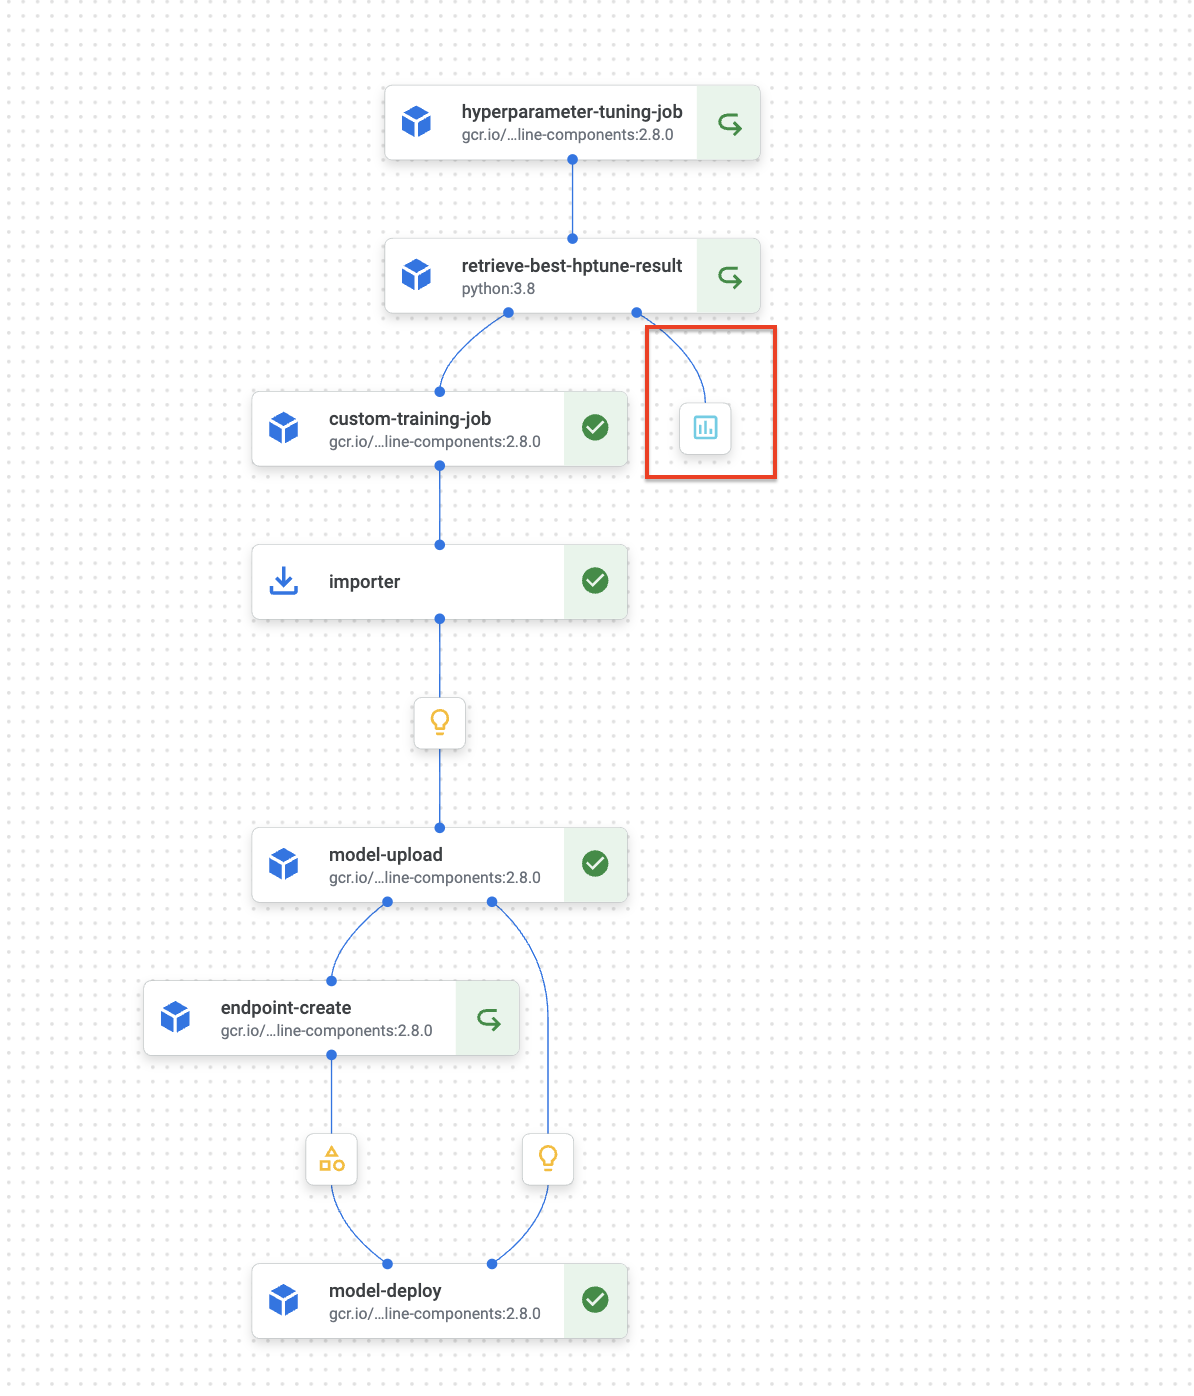

---

Vertex AI Experiments:

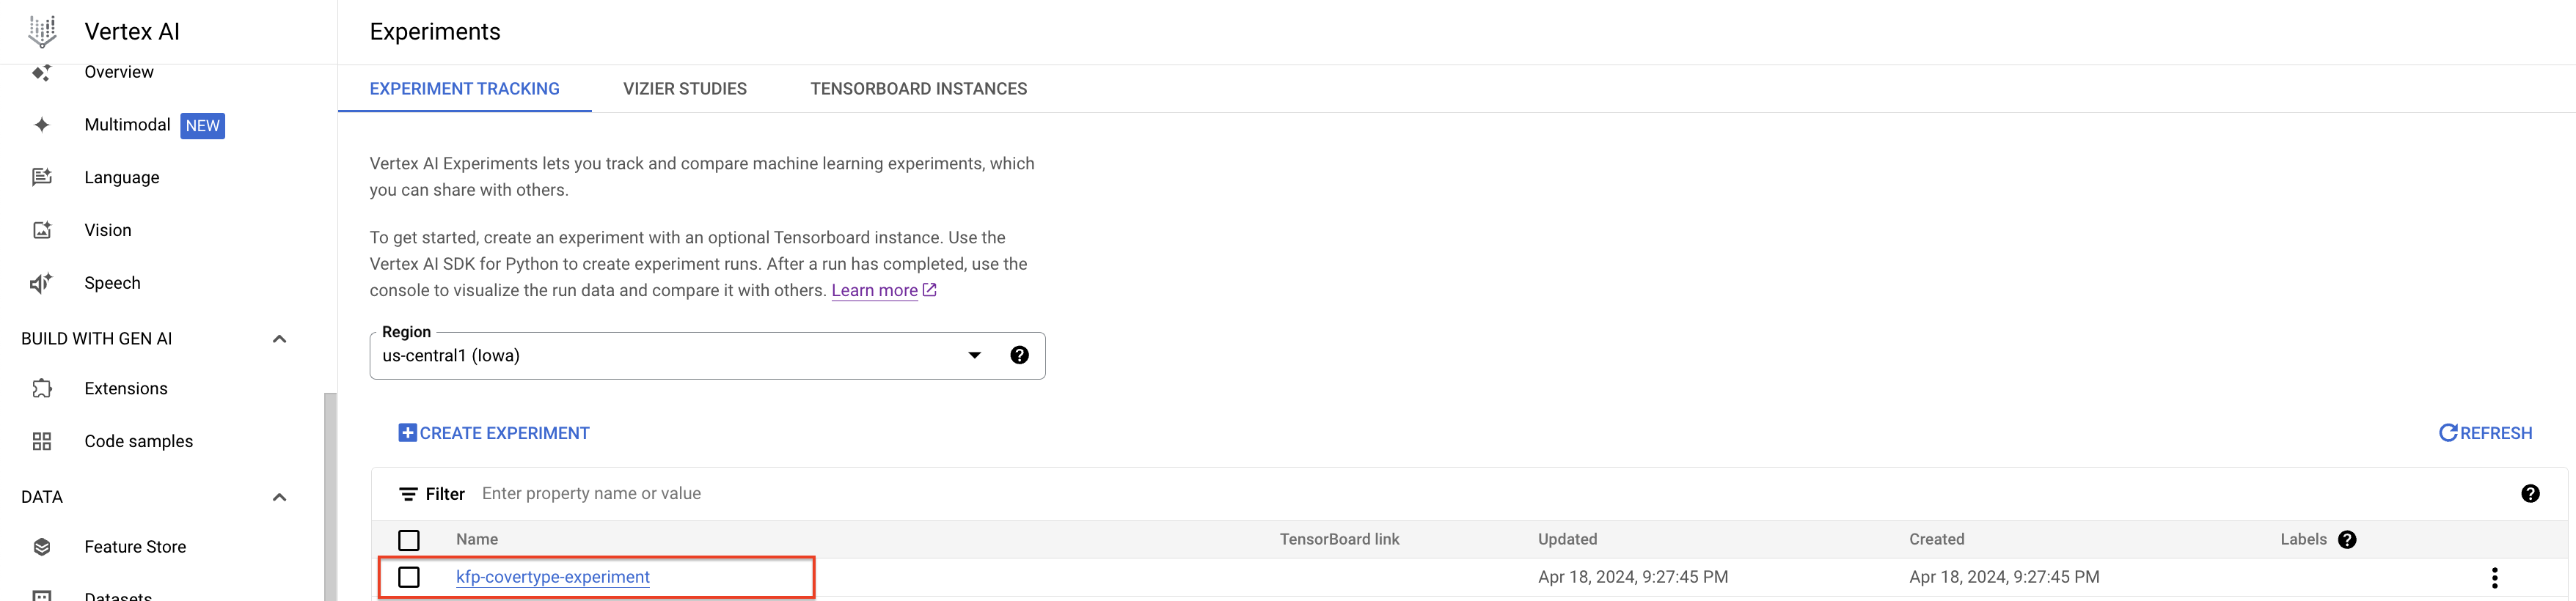


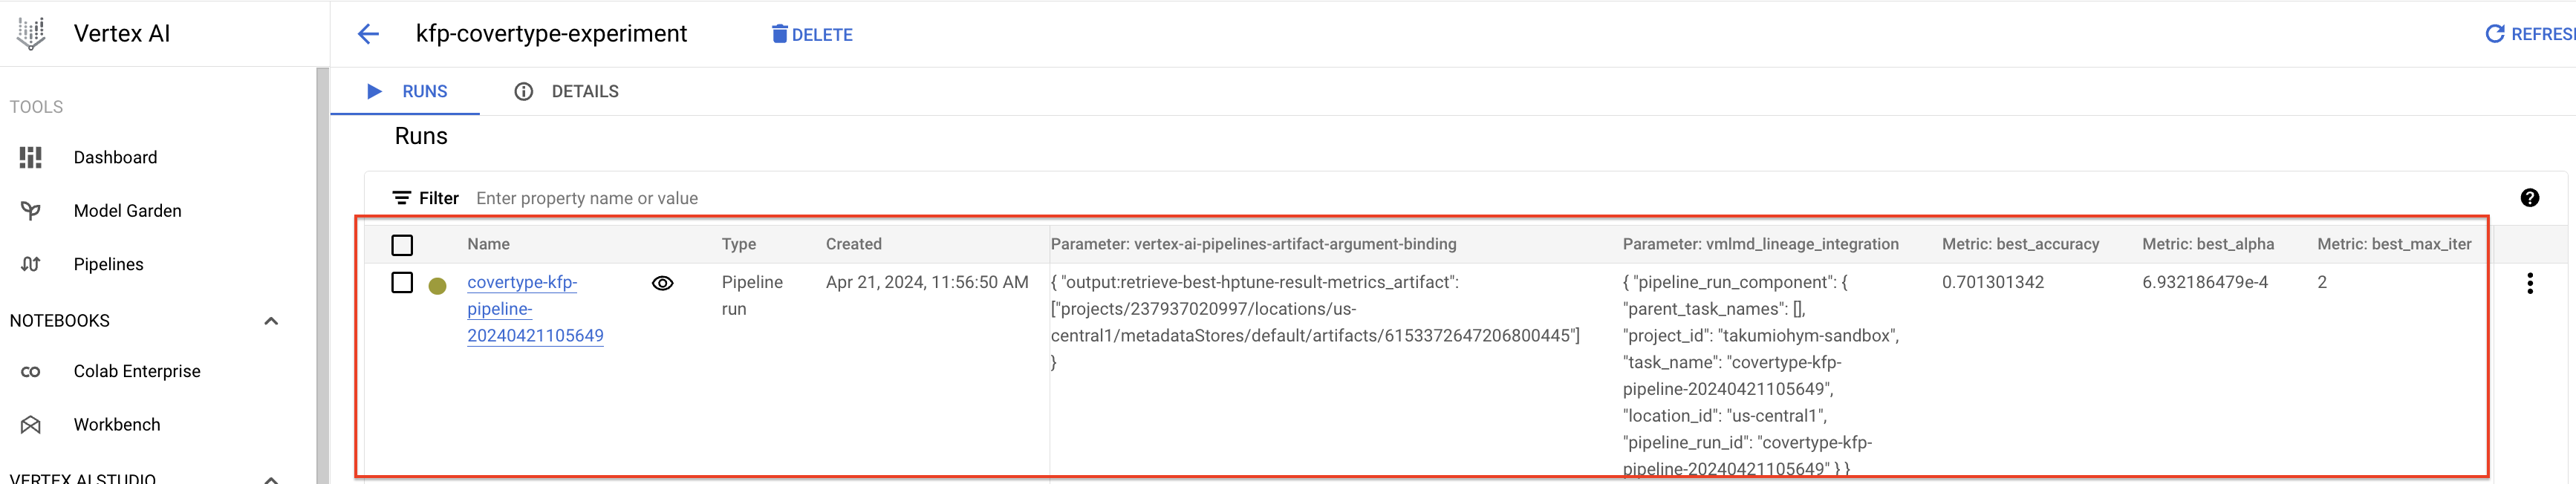


## Compile and run the pipeline

Let stat by defining the environment variables that will be passed to the pipeline compiler:

In [104]:
ARTIFACT_STORE = f"gs://{PROJECT_ID}-kfp-artifact-store"
PIPELINE_ROOT = f"{ARTIFACT_STORE}/pipeline"
DATA_ROOT = f"{ARTIFACT_STORE}/data"

TRAINING_FILE_PATH = f"{DATA_ROOT}/training/dataset.csv"
VALIDATION_FILE_PATH = f"{DATA_ROOT}/validation/dataset.csv"

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BASE_OUTPUT_DIR = f"{ARTIFACT_STORE}/models/{TIMESTAMP}"

%env PIPELINE_ROOT={PIPELINE_ROOT}
%env PROJECT_ID={PROJECT_ID}
%env REGION={REGION}
%env SERVING_CONTAINER_IMAGE_URI={SERVING_CONTAINER_IMAGE_URI}
%env TRAINING_CONTAINER_IMAGE_URI={TRAINING_CONTAINER_IMAGE_URI}
%env TRAINING_FILE_PATH={TRAINING_FILE_PATH}
%env VALIDATION_FILE_PATH={VALIDATION_FILE_PATH}
%env BASE_OUTPUT_DIR={BASE_OUTPUT_DIR}

env: PIPELINE_ROOT=gs://takumiohym-sandbox-kfp-artifact-store/pipeline
env: PROJECT_ID=takumiohym-sandbox
env: REGION=us-central1
env: SERVING_CONTAINER_IMAGE_URI=us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest
env: TRAINING_CONTAINER_IMAGE_URI=us-docker.pkg.dev/takumiohym-sandbox/asl-artifact-repo/trainer_image_covertype_vertex:latest
env: TRAINING_FILE_PATH=gs://takumiohym-sandbox-kfp-artifact-store/data/training/dataset.csv
env: VALIDATION_FILE_PATH=gs://takumiohym-sandbox-kfp-artifact-store/data/validation/dataset.csv
env: BASE_OUTPUT_DIR=gs://takumiohym-sandbox-kfp-artifact-store/models/20240421105628


Let us make sure that the `ARTIFACT_STORE` has been created, and let us create it if not:

In [105]:
!gsutil ls | grep ^{ARTIFACT_STORE}/$ || gsutil mb -l {REGION} {ARTIFACT_STORE}

gs://takumiohym-sandbox-kfp-artifact-store/


**Note:** In case the artifact store was not created and properly set before hand, you may need
to run in **CloudShell** the following command to allow Vertex AI to access it:

```
PROJECT_ID=$(gcloud config get-value project)
PROJECT_NUMBER=$(gcloud projects list --filter="name=$PROJECT_ID" --format="value(PROJECT_NUMBER)")
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$PROJECT_NUMBER-compute@developer.gserviceaccount.com" \
    --role="roles/storage.objectAdmin"
```

#### Use the CLI compiler to compile the pipeline

We compile the pipeline from the Python file we generated into a JSON description using the following command:

In [106]:
PIPELINE_YAML = "covertype_kfp_pipeline-lab1.yaml"

In [107]:
!kfp dsl compile --py pipeline_vertex/pipeline.py --output $PIPELINE_YAML

/home/jupyter/asl-ml-immersion/notebooks/kubeflow_pipelines/pipelines/challenge_labs/covertype_kfp_pipeline-lab1.yaml


**Note:** You can also use the Python SDK to compile the pipeline:

```python
from kfp import compiler

compiler.Compiler().compile(
    pipeline_func=create_pipeline, 
    package_path=PIPELINE_YAML,
)

```

The result is the pipeline file. 

In [108]:
!head {PIPELINE_YAML}

# PIPELINE DEFINITION
# Name: covertype-kfp-pipeline
# Description: Kubeflow pipeline that tunes, trains, and deploys on Vertex
# Outputs:
#    retrieve-best-hptune-result-metrics_artifact: system.Metrics
components:
  comp-custom-training-job:
    executorLabel: exec-custom-training-job
    inputDefinitions:
      parameters:


### Deploy and run the pipeline package

In [109]:
EXPERIMENT_NAME = "kfp-covertype-experiment"

In [110]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    experiment_tensorboard=False,
)

pipeline = aiplatform.PipelineJob(
    display_name="covertype_kfp_pipeline_challenge_lab",
    template_path=PIPELINE_YAML,
    enable_caching=True,
)

pipeline.submit(experiment=EXPERIMENT_NAME)

Creating PipelineJob
PipelineJob created. Resource name: projects/237937020997/locations/us-central1/pipelineJobs/covertype-kfp-pipeline-20240421105649
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/237937020997/locations/us-central1/pipelineJobs/covertype-kfp-pipeline-20240421105649')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/covertype-kfp-pipeline-20240421105649?project=237937020997
Associating projects/237937020997/locations/us-central1/pipelineJobs/covertype-kfp-pipeline-20240421105649 to Experiment: kfp-covertype-experiment


Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.